### Binary Classification Models

In [1]:
# Import Statements

import sys
import math
import warnings
import joblib
import os
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import binarize
from sklearn.covariance import EllipticEnvelope

from imblearn.over_sampling import RandomOverSampler 

warnings.filterwarnings('ignore')

### Initializations

In [2]:
# Box Folder Location containing data files

home_dir = os.path.expanduser('~')

apple_folder_loc = home_dir + "/Library/CloudStorage/Box-Box/Capstone/Capstone/Data Science Capstone/Data"
windows_folder_loc = home_dir + "~/Box/Capstone/Capstone/Data Science Capstone/Data"
linux_folder_loc = ""

data_folder_loc = apple_folder_loc if sys.platform.startswith("darwin") else (windows_folder_loc if sys.platform.startswith("win") else linux_folder_loc)

In [3]:
folder_to_read_for_input_files = "FeatureSelection"
folder_to_save_model = "Models"
random_state = 265
target_level_column = 'ActivationLevel'
reporting_df = pd.DataFrame(columns=['File Name', 'Model', 'Accuracy', 'R-Square', 'Adjusted-R-Square', 'MAE',
                                    'Precision_0', 'Recall_0', 'F1_0', 'Support_0', 'Precision_1', 'Recall_1', 'F1_1', 'Support_1',
                                    'OverTriage_Rate', 'UnderTriage_Rate'])

### Functions to automate

In [4]:
def load_dataset(file_path):
    
    print("\nLoading File {}\n".format(file_path.split("/")[-1]))
    
    data = pd.read_excel(file_path)
    return data

In [5]:
def perform_train_test_split(X, Y, test_size=0.30, random_state=1):
    
    print("Performing {}/{} Train-Test Split".format((1-test_size) * 100, test_size * 100))
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [6]:
def get_classification_report(X_test, y_test, y_pred):
    
    print("\nFinding Classification Report\n")
    
    r_sq = metrics.r2_score(y_pred, y_test)
    adj_r_sq = 1 - (1 - metrics.r2_score(y_test, y_pred)) * ((len(X_test) - 1) / (len(X_test) - X_test.shape[1] - 1))
    
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    report['R-Square'] = r_sq
    report['Adjusted-R-Square'] = adj_r_sq
    
    report['mae'] = mean_absolute_error(y_test, y_pred)
    
    return report

In [7]:
def save_model(model, file_name, model_name):
    
    print("\nSaving model {} \n".format(model_name))
    
    joblib.dump(model, "{}/{}/ModelObjects/{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name))

In [8]:
def load_model(model, model_name):
    
    print("\nLoading Model {}\n", model_name)
    
    return joblib.load("{}/{}/ModelObjects/{}".format(data_folder_loc, folder_to_save_model, model_name))

In [9]:
def make_report(X_test, y_test, y_pred, model, model_name, file_name, reporting_df):
    classification_report = get_classification_report(X_test, y_test, y_pred)
    reporting_df = reporting_df.append(
        {
            'File Name': file_name,
            'Model': model_name,
            'Accuracy': classification_report['accuracy'],
            'R-Square': classification_report['R-Square'],
            'Adjusted-R-Square': classification_report['Adjusted-R-Square'],
            'MAE': classification_report['mae'],
            'Precision_0': classification_report['0'].get('precision'),
            'Recall_0': classification_report['0'].get('recall'),
            'F1_0': classification_report['0'].get('f1-score'),
            'Support_0': classification_report['0'].get('support'),
            'Precision_1': classification_report['1'].get('precision'),
            'Recall_1': classification_report['1'].get('recall'),
            'F1_1': classification_report['1'].get('f1-score'),
            'Support_1': classification_report['1'].get('support'),
            'OverTriage_Rate': 1 - float(classification_report['1'].get('precision')),
            'UnderTriage_Rate': 1 - float(classification_report['0'].get('precision'))
        },
        ignore_index=True
    )
    save_model(model, file_name, model_name)
    return reporting_df

In [10]:
def get_model_name(model_name, anomaly_detection):
    return "{}_{}".format(model_name, "AnomalyDetection") if anomaly_detection else model_name

### OverSampling

In [11]:
def perform_oversampling():
    
    print("\nPerforming Oversampling since data labels are distributed as follows:\n")
    data_labels.value_counts()
    
    return RandomOverSampler().fit_resample(data_features, data_labels)

### Stratified Sampling with Cross Validation

In [12]:
def perform_stratified_sampling(X, y, model, n_splits=10, n_repeats=3, n_jobs=-1):
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_jobs, error_score='raise')

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

### Bagging Regressor

In [13]:
def perform_bagging(X_train, y_train, X_test, y_test, model, n_estimators, file_name, reporting_df):
    
    print("\nPerforming Bagging Regression\n")
    
    bagging_model = BaggingRegressor(model, n_estimators=n_estimators)
    bagging_model.fit(X_train, y_train)

    test_preds_grid = bagging_model.predict(X_test)
    y_pred = np.round(test_preds_grid).astype(int)
    
    return make_report(X_test, y_test, y_pred, bagging_model, "Bagging Regressor", file_name, reporting_df)

### ROC Curve

In [14]:
def plot_roc_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)

    # create ROC curve
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("{}/{}/RocCurves/{}_{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name, 'roc_curve.png', dpi=120))
    plt.show()

In [15]:
def plot_precision_recall_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob)
    
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig("{}/{}/PrecisionRecallCurves/{}_{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name, 'precision_recall_curve.png', dpi=120))
    plt.show()

In [16]:
def store_roc_auc_scores_at_different_thresholds(y_test, y_pred_prob):
    
    df = pd.DataFrame(columns=['Threshold', 'ROC-AUC Score', 'Accuracy', 'Recall_1', 'Recall_0', 
                               'Precision_1', 'Precision_0', 'OverTriage_Rate', 'UnderTriage_Rate'])
    
    for threshold in np.arange(0.2, 0.8, 0.025):
        
        y_pred_class = binarize(y_pred_prob.reshape(1, -1), threshold=threshold)[0].astype(int)
        report = metrics.classification_report(y_test, y_pred_class, output_dict=True)
        
        df = df.append({
            'Threshold': threshold,
            'ROC-AUC Score': metrics.roc_auc_score(y_test, y_pred_class),
            'Accuracy': metrics.accuracy_score(y_test, y_pred_class),
            'Recall_1': report['1'].get('recall'),
            'Recall_0': report['0'].get('recall'),
            'Precision_1': report['1'].get('precision'),
            'Precision_0': report['0'].get('precision'),
            'OverTriage_Rate': 1 - float(report['1'].get('precision')),
            'UnderTriage_Rate': 1 - float(report['0'].get('precision'))
        }, 
            ignore_index=True
        )
    
    return df

In [17]:
def play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model):
    plot_roc_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)
    plot_precision_recall_curve(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)
    df = store_roc_auc_scores_at_different_thresholds(y_test, y_pred_prob)
    df.to_excel("{}/{}/Thresholds/{}_{}_ROC_AUC.xlsx".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], model_name))

### Logistic Regression

In [18]:
def perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming Logistic Regression\n")
    model_name = get_model_name("LogisticRegression", anomaly_detection)
    
    logreg = LogisticRegression(random_state=random_state)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    play_with_roc_auc_precision_recall(y_test, logreg.predict_proba(X_test)[:,1], model_name, file_name, data_folder_loc, folder_to_save_model)

    logit_model = sm.Logit(data_labels, data_features)
    result = logit_model.fit()
    print("\nSummary for Logit Model:\n\n", result.summary2())

    return make_report(X_test, y_test, y_pred, logreg, model_name, file_name, reporting_df)

### SVM

In [19]:
def perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming SVM Classification\n")
    model_name = get_model_name("SVM", anomaly_detection)
    
    parameters= {'kernel': ('linear', 'rbf', 'poly'), 'C': [1, 10, 100], 'degree': [2]}
    
    gridsearch = GridSearchCV(svm.SVC(), parameters)
    gridsearch.fit(X_train, y_train)
    
    best_kernel, best_c = gridsearch.best_params_['kernel'], gridsearch.best_params_['C']
    print(gridsearch.best_params_)
    best_model = svm.SVC(kernel=best_kernel, C=best_c)
    
    best_model.fit(X_train, y_train)
    
    if best_kernel == 'linear':
        
        print('\nw = ',best_model.coef_)
        print('\nb = ',best_model.intercept_)
        print('\nIndices of support vectors = ', best_model.support_)
        print('\nSupport vectors = ', best_model.support_vectors_)
        print('\nNumber of support vectors for each class = ', best_model.n_support_)
        print('\nCoefficients of the support vector in the decision function = ', np.abs(best_model.dual_coef_))        
    
    elif best_kernel == 'poly':
        best_degree = gridsearch.best_params_['degree']
        best_model = svm.SVC(kernel=best_kernel, C=best_c, degree=best_degree)
        best_model.fit(X_train, y_train)
    
    y_pred_prob = best_model.predict(X_test)
    play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(y_pred_prob).astype(int)
    
    return make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)

### KNN

#### KNN Regressor

In [20]:
def perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming KNN Regression\n")
    model_name = get_model_name("KNNRegressor", anomaly_detection)
    
    parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
    gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
    gridsearch.fit(X_train, y_train)
    
    best_n_neighbors, best_weight_technique = gridsearch.best_params_['n_neighbors'], gridsearch.best_params_['weights']
    print(gridsearch.best_params_)
    best_model = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights=best_weight_technique)
    best_model.fit(X_train, y_train)

    y_pred_prob = best_model.predict(X_test)
    play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(y_pred_prob).astype(int)
    
    return make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)

#### KNN Classifier

In [21]:
def perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=False):
    
    print("\nPerforming KNN Classification\n")
    model_name = get_model_name("KNNClassifier", anomaly_detection)
    
    parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
    
    gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
    gridsearch.fit(X_train, y_train)

    print("{} Features used during classification: {}".format(gridsearch.n_features_in_, gridsearch.feature_names_in_))

    best_n_neighbors, best_weight_technique = gridsearch.best_params_['n_neighbors'], gridsearch.best_params_['weights']
    print(gridsearch.best_params_)
    best_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weight_technique)
    best_model.fit(X_train, y_train)

    y_pred_prob = best_model.predict(X_test)
    play_with_roc_auc_precision_recall(y_test, y_pred_prob, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(y_pred_prob).astype(int)
    
    return make_report(X_test, y_test, y_pred, best_model, model_name, file_name, reporting_df)

### RandomForest

#### Random Forest Regressor

In [22]:
def perform_random_forest_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, n_estimators=1000):
    
    print("\nPerforming Random Forest Regression\n")
    model_name = "RandomForestRegressor"
    
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    play_with_roc_auc_precision_recall(y_test, predictions, model_name, file_name, data_folder_loc, folder_to_save_model)

    y_pred = np.round(predictions).astype(int)
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

    return make_report(X_test, y_test, y_pred, rf, model_name, file_name, reporting_df)

#### Random Forest Classifier

In [23]:
def perform_random_forest_classifier(data_features, data_labels):
    
    print("\nPerforming Random Forest Classification\n")

    # get a list of models to evaluate
    def get_models():
        models = dict()
        # explore ratios from 10% to 100% in 10% increments
        for i in np.arange(0.1, 1.1, 0.1):
            key = '%.1f' % i
            # set max_samples=None to use 100%
            if i == 1.0:
                i = None
            models[key] = RandomForestClassifier(max_samples=i)
        return models
    
    models = get_models()
    for name, model in models.items():
        print('\n>{}'.format(name))
        perform_stratified_sampling(data_features, data_labels, model)

### Gaussian Naive-Bayes

In [24]:
def perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df, anomaly_detection=False):
    
    print("\nPerforming Gaussian Naive Bayes\n")
    model_name = get_model_name("GaussianNaiveBayes", anomaly_detection)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)
    
    return make_report(X_test, y_test, y_pred, gnb, model_name, file_name, reporting_df)

### Anomaly Detection

#### IsolationForest

In [25]:
def perform_isolation_forest(X_train, contamination):
    
    print("\nPerforming Isolation Forest Anomaly Detection\n")
    
    iso = IsolationForest(contamination=contamination)
    yhat = iso.fit_predict(X_train)
    
    return yhat

#### Elliptic Envelope (Minimum Covariance Determinant) (based upon Gaussian Distribution)

In [26]:
def perform_elliptic_envelope(X_train, contamination):
    
    print("\nPerforming Minimum Covariance Determinant Anomaly Detection\n")
    
    ee = EllipticEnvelope(contamination=contamination)
    yhat = ee.fit_predict(X_train)
    
    return yhat

#### Local Outlier Factor (based upon nearest neighbors)

In [27]:
def perform_local_outlier_factor(X_train, contamination):
    
    print("\nPerforming Local Outlier Factor Anomaly Detection\n")
    
    lof = LocalOutlierFactor(contamination=contamination)
    yhat = lof.fit_predict(X_train)
    
    return yhat

#### One-Class SVM

In [28]:
def perform_one_class_svm(X_train, contamination):
    
    print("\nPerforming One Class SVM Anomaly Detection\n")
    
    ee = svm.OneClassSVM(nu=contamination)
    yhat = ee.fit_predict(X_train)
    
    return yhat

#### Summary

In [29]:
def print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat):
    
    # select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train.iloc[mask, :], y_train[mask]
    
    # summarize the shape of the updated training dataset
    print(X_train.shape, y_train.shape)
    
    return X_train, y_train

In [30]:
def perform_anomaly_detection(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model):
    
    print("\nPerforming Anomaly Detection\n")
    
    contamination = round(y_train.value_counts()[1] / y_train.value_counts().sum(), 2)
    
    yhat = perform_isolation_forest(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
    
    yhat = perform_elliptic_envelope(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df, anomaly_detection=True)
    
    yhat = perform_local_outlier_factor(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
    reporting_df = perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)
        
    yhat = perform_one_class_svm(X_train, contamination)
    X_train, y_train = print_shape_of_updated_train_data_after_anomaly_removal(X_train, y_train, yhat)
    reporting_df = perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model, anomaly_detection=True)

    return reporting_df

### T-SNE

In [31]:
def create_tsne(data, target_column_name, data_folder_loc, folder_to_save_model, file_name):
    
    print("\nt-SNE\n")
    
    # That's an impressive list of imports.
    import numpy as np
    from numpy import linalg
    from numpy.linalg import norm
    from scipy.spatial.distance import squareform, pdist

    # We import sklearn.
    import sklearn
    from sklearn.manifold import TSNE
    from sklearn.datasets import load_digits
    from sklearn.preprocessing import scale

    # We'll hack a bit with the t-SNE code in sklearn 0.15.2.
    from sklearn.metrics.pairwise import pairwise_distances
    from sklearn.manifold._t_sne import (_joint_probabilities,
                                        _kl_divergence)
    # from sklearn.utils.extmath import _ravel
    # Random state.
    RS = 20150101

    # We'll use matplotlib for graphics.
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    import matplotlib
    %matplotlib inline

    # We import seaborn to make nice plots.
    import seaborn as sns
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context("notebook", font_scale=1.5,
                    rc={"lines.linewidth": 2.5})

    # We first reorder the data points according to the handwritten numbers.
    X = np.vstack([data[data[target_column_name]==i].drop([target_column_name], axis=1)
                   for i in range(2)])
    y = np.hstack([data[data[target_column_name]==i][target_column_name]
                   for i in range(2)])

    digits_proj = TSNE(random_state=RS).fit_transform(X)

    def scatter(x, colors):
        # We choose a color palette with seaborn.
        palette = np.array(sns.color_palette("hls", 2))

        # We create a scatter plot.
        f = plt.figure(figsize=(8, 8))
        ax = plt.subplot(aspect='equal')
        sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                        c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        ax.axis('off')
        ax.axis('tight')

        # We add the labels for each digit.
        txts = []
        for i in range(2):
            # Position of each label.
            xtext, ytext = np.median(x[colors == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)

        return f, ax, sc, txts

    scatter(digits_proj, y)
    plt.savefig("{}/{}/tsne/{}_{}".format(data_folder_loc, folder_to_save_model, file_name.split(".xlsx")[0], 'tsne.png', dpi=120))
    plt.show()

### Read Data Files (xlsx) and run models


Loading File RFE15.xlsx

Performing 70.0/30.0 Train-Test Split

Shape of data: X_train: (3596, 20), y_train: (3596,), X_test: (1542, 20), y_test: (1542,)

Distribution of class labels:
Train:
0    2806
1     790
Name: ActivationLevel, dtype: int64

Test:
0    1220
1     322
Name: ActivationLevel, dtype: int64


Performing Logistic Regression



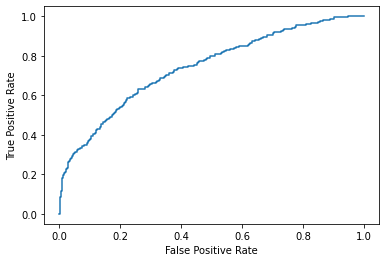

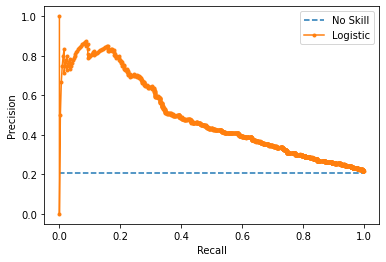

         Current function value: 0.445712
         Iterations: 35

Summary for Logit Model:

                                   Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.147      
Dependent Variable:        ActivationLevel       AIC:                   4620.1414  
Date:                      2023-03-06 17:19      BIC:                   4751.0298  
No. Observations:          5138                  Log-Likelihood:        -2290.1    
Df Model:                  19                    LL-Null:               -2683.8    
Df Residuals:              5118                  LLR p-value:           9.7172e-155
Converged:                 0.0000                Scale:                 1.0000     
No. Iterations:            35.0000                                                 
-----------------------------------------------------------------------------------
                    Coef.    Std.Err.      z    P>|z|      [0.025         0.975]   
-----------------

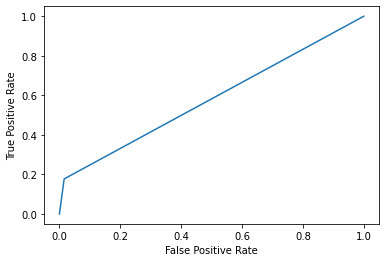

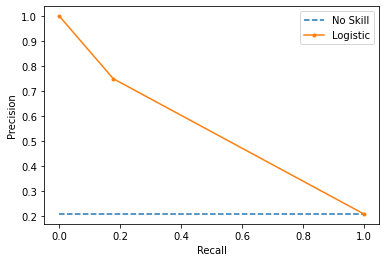


Finding Classification Report


Saving model SVM 


Performing KNN Regression

{'n_neighbors': 41, 'weights': 'distance'}


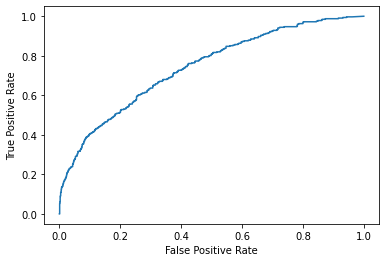

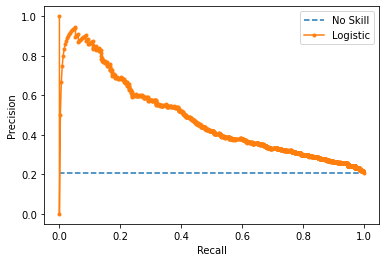


Finding Classification Report


Saving model KNNRegressor 


Performing KNN Classification

20 Features used during classification: ['ASSAULT' 'OTHER' 'STAB' 'IVFunk' 'PELVIC' 'SUCK' 'NEEDLE' 'CPR'
 'ChestTube' 'EmergentIntubation' 'ICP' 'Craniotomy' 'WorstPHSBP'
 'FirstPHGCS' 'WorstPHGCS' 'FirstPHPulse' 'BestPHPulse' 'FirstPHRTS'
 'WorstPHSBPNorm' 'Age']
{'n_neighbors': 21, 'weights': 'distance'}


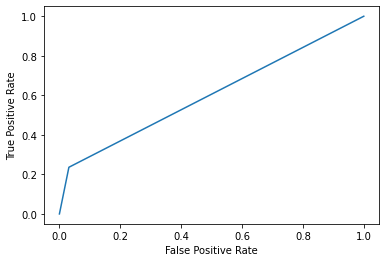

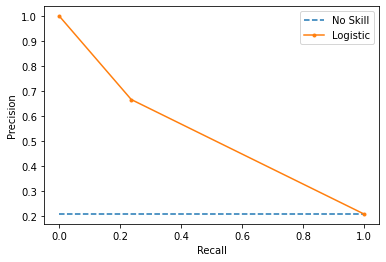


Finding Classification Report


Saving model KNNClassifier 


Performing Random Forest Regression



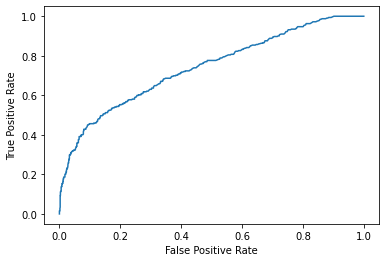

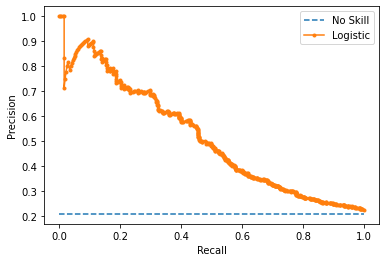

Variable: Age                  Importance: 0.25
Variable: FirstPHPulse         Importance: 0.12
Variable: BestPHPulse          Importance: 0.12
Variable: WorstPHSBP           Importance: 0.11
Variable: WorstPHSBPNorm       Importance: 0.1
Variable: FirstPHGCS           Importance: 0.07
Variable: ChestTube            Importance: 0.05
Variable: WorstPHGCS           Importance: 0.05
Variable: FirstPHRTS           Importance: 0.05
Variable: EmergentIntubation   Importance: 0.02
Variable: ASSAULT              Importance: 0.01
Variable: OTHER                Importance: 0.01
Variable: STAB                 Importance: 0.01
Variable: IVFunk               Importance: 0.01
Variable: SUCK                 Importance: 0.01
Variable: ICP                  Importance: 0.01
Variable: Craniotomy           Importance: 0.01
Variable: PELVIC               Importance: 0.0
Variable: NEEDLE               Importance: 0.0
Variable: CPR                  Importance: 0.0

Finding Classification Report


Saving mode

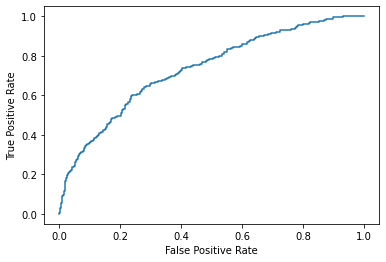

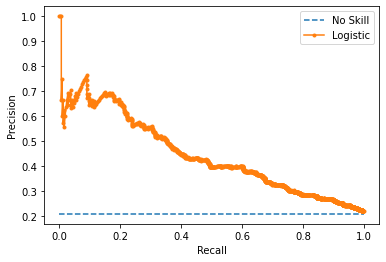

         Current function value: 0.445712
         Iterations: 35

Summary for Logit Model:

                                   Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.147      
Dependent Variable:        ActivationLevel       AIC:                   4620.1414  
Date:                      2023-03-06 17:22      BIC:                   4751.0298  
No. Observations:          5138                  Log-Likelihood:        -2290.1    
Df Model:                  19                    LL-Null:               -2683.8    
Df Residuals:              5118                  LLR p-value:           9.7172e-155
Converged:                 0.0000                Scale:                 1.0000     
No. Iterations:            35.0000                                                 
-----------------------------------------------------------------------------------
                    Coef.    Std.Err.      z    P>|z|      [0.025         0.975]   
-----------------

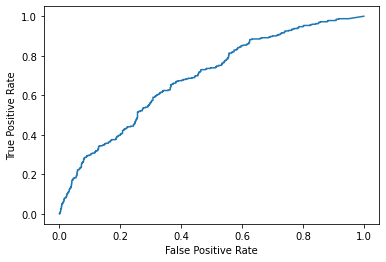

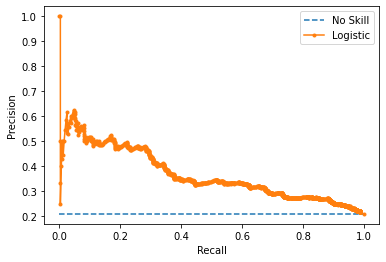


Finding Classification Report


Saving model KNNRegressor_AnomalyDetection 


Performing KNN Classification

20 Features used during classification: ['ASSAULT' 'OTHER' 'STAB' 'IVFunk' 'PELVIC' 'SUCK' 'NEEDLE' 'CPR'
 'ChestTube' 'EmergentIntubation' 'ICP' 'Craniotomy' 'WorstPHSBP'
 'FirstPHGCS' 'WorstPHGCS' 'FirstPHPulse' 'BestPHPulse' 'FirstPHRTS'
 'WorstPHSBPNorm' 'Age']
{'n_neighbors': 31, 'weights': 'distance'}


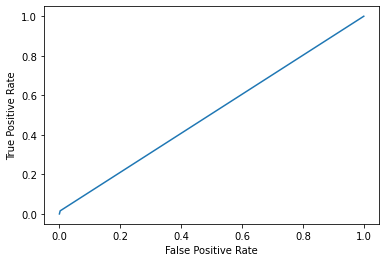

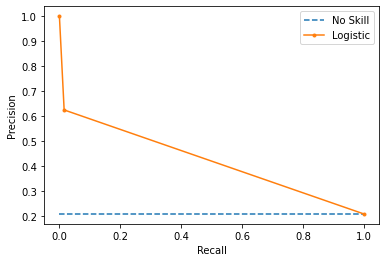


Finding Classification Report


Saving model KNNClassifier_AnomalyDetection 


Performing One Class SVM Anomaly Detection

(1331, 20) (1331,)

Performing SVM Classification

{'C': 1, 'degree': 2, 'kernel': 'linear'}

w =  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.43302405e-04  1.73426766e-02 -1.21721267e-02  1.24077803e-02
  -1.34473333e-02 -1.04394141e-02  2.43298129e-04  4.65056610e-05]]

b =  [-0.99501153]

Indices of support vectors =  [   5    7   13   16   25   30   31   33   37   42   45   54   57   58
   67   68   80   88   95  100  116  123  128  145  157  159  160  179
  184  188  190  218  219  223  233  244  254  266  270  281  291  293
  298  308  314  317  331  338  350  355  357  369  380  391  394  395
  410  414  417  420  421  426  431  443  448  471  481  484  487  513
  527  535  543  554  560  562  567  57

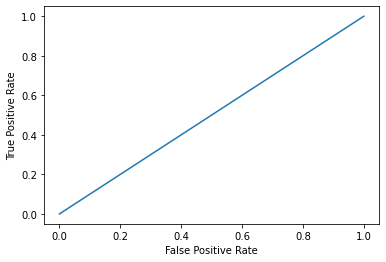

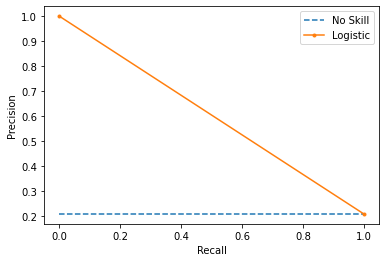


Finding Classification Report


Saving model SVM_AnomalyDetection 


t-SNE



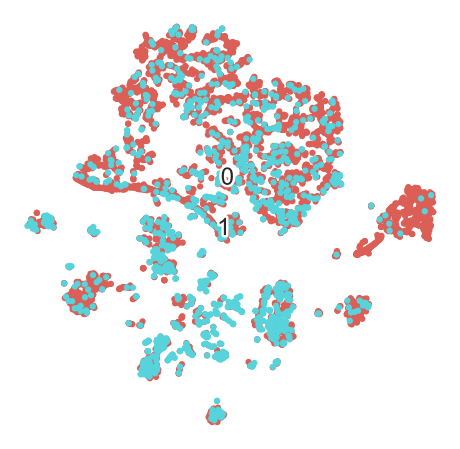


Loading File chi15.xlsx

Performing 70.0/30.0 Train-Test Split

Shape of data: X_train: (3596, 15), y_train: (3596,), X_test: (1542, 15), y_test: (1542,)

Distribution of class labels:
Train:
0    2806
1     790
Name: ActivationLevel, dtype: int64

Test:
0    1220
1     322
Name: ActivationLevel, dtype: int64


Performing Logistic Regression



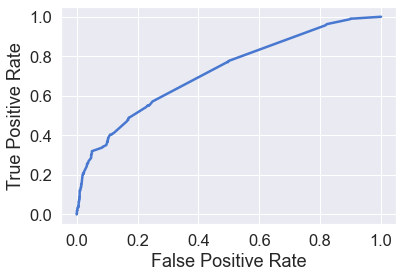

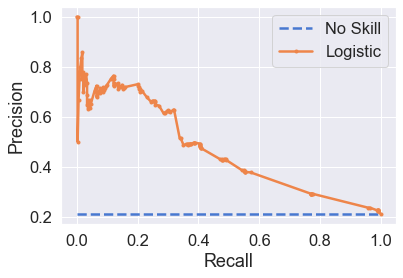

Optimization terminated successfully.
         Current function value: 0.575788
         Iterations 7

Summary for Logit Model:

                            Results: Logit
Model:                Logit             Pseudo R-squared:  -0.102   
Dependent Variable:   ActivationLevel   AIC:               5946.8000
Date:                 2023-03-06 17:22  BIC:               6044.9663
No. Observations:     5138              Log-Likelihood:    -2958.4  
Df Model:             14                LL-Null:           -2683.8  
Df Residuals:         5123              LLR p-value:       1.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
STAB                -1.3786   0.2107  -6.5419 0.0000 -1.7916 -0.9656


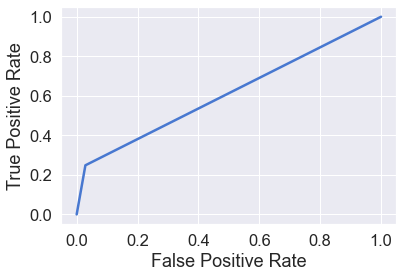

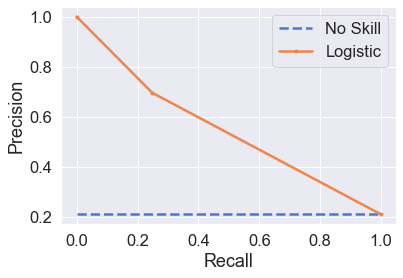


Finding Classification Report


Saving model SVM 


Performing KNN Regression

{'n_neighbors': 42, 'weights': 'uniform'}


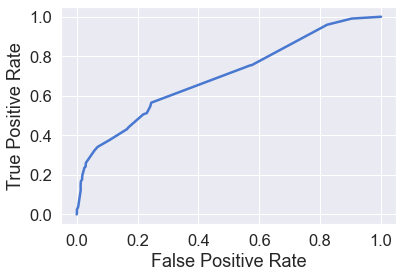

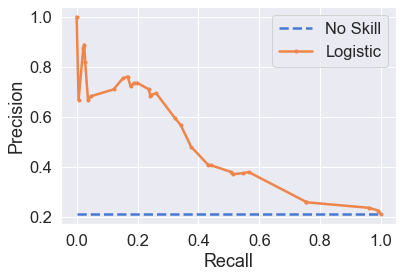


Finding Classification Report


Saving model KNNRegressor 


Performing KNN Classification

15 Features used during classification: ['STAB' 'SPINE' 'IO' 'O2' 'BVM' 'ETT' 'SUCK' 'LMA' 'ORAL' 'NEEDLE'
 'ChestTube' 'EmergentIntubation' 'ICP' 'Craniotomy' 'BvsPIdx_Penetrating']
{'n_neighbors': 33, 'weights': 'uniform'}


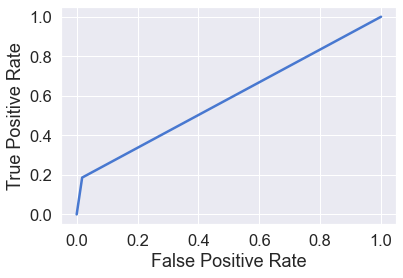

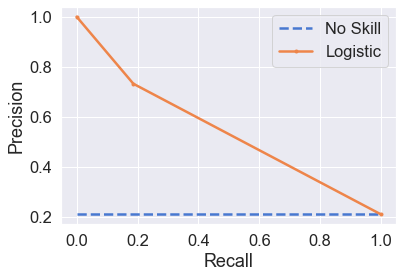


Finding Classification Report


Saving model KNNClassifier 


Performing Random Forest Regression



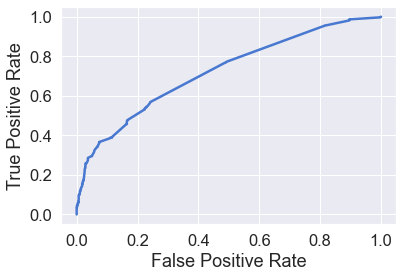

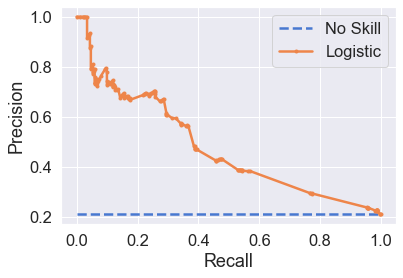

Variable: ChestTube            Importance: 0.22
Variable: EmergentIntubation   Importance: 0.14
Variable: O2                   Importance: 0.09
Variable: SPINE                Importance: 0.06
Variable: BVM                  Importance: 0.06
Variable: BvsPIdx_Penetrating  Importance: 0.06
Variable: STAB                 Importance: 0.05
Variable: IO                   Importance: 0.05
Variable: ETT                  Importance: 0.05
Variable: SUCK                 Importance: 0.05
Variable: ICP                  Importance: 0.04
Variable: Craniotomy           Importance: 0.04
Variable: LMA                  Importance: 0.03
Variable: NEEDLE               Importance: 0.03
Variable: ORAL                 Importance: 0.02

Finding Classification Report


Saving model RandomForestRegressor 


Performing Random Forest Classification


>0.1
Accuracy: 0.806 (0.013)

>0.2
Accuracy: 0.808 (0.013)

>0.3
Accuracy: 0.806 (0.014)

>0.4
Accuracy: 0.806 (0.015)

>0.5
Accuracy: 0.806 (0.014)

>0.6
Accuracy: 0.

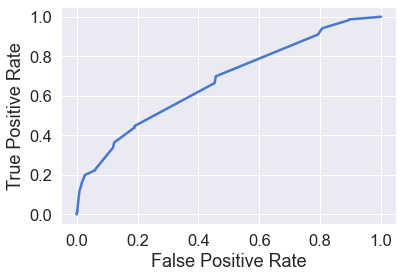

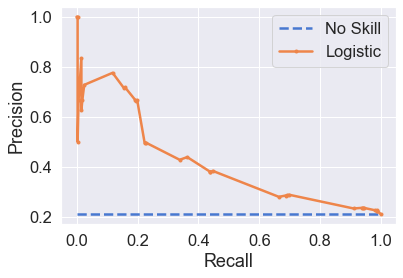

Optimization terminated successfully.
         Current function value: 0.575788
         Iterations 7

Summary for Logit Model:

                            Results: Logit
Model:                Logit             Pseudo R-squared:  -0.102   
Dependent Variable:   ActivationLevel   AIC:               5946.8000
Date:                 2023-03-06 17:24  BIC:               6044.9663
No. Observations:     5138              Log-Likelihood:    -2958.4  
Df Model:             14                LL-Null:           -2683.8  
Df Residuals:         5123              LLR p-value:       1.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
STAB                -1.3786   0.2107  -6.5419 0.0000 -1.7916 -0.9656


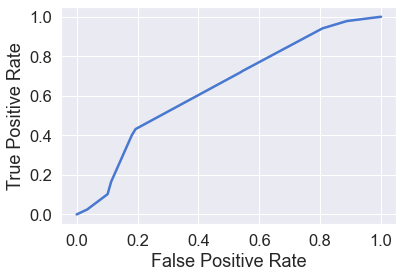

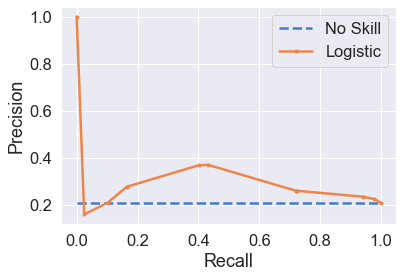


Finding Classification Report


Saving model KNNRegressor_AnomalyDetection 


Performing KNN Classification

15 Features used during classification: ['STAB' 'SPINE' 'IO' 'O2' 'BVM' 'ETT' 'SUCK' 'LMA' 'ORAL' 'NEEDLE'
 'ChestTube' 'EmergentIntubation' 'ICP' 'Craniotomy' 'BvsPIdx_Penetrating']
{'n_neighbors': 2, 'weights': 'uniform'}


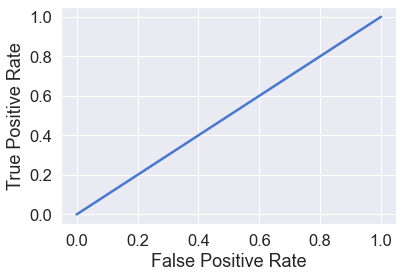

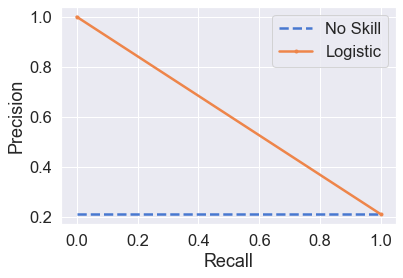


Finding Classification Report


Saving model KNNClassifier_AnomalyDetection 


Performing One Class SVM Anomaly Detection

(1262, 15) (1262,)

Performing SVM Classification

{'C': 1, 'degree': 2, 'kernel': 'linear'}

w =  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

b =  [-1.]

Indices of support vectors =  [ 876  882  884  914  930  943  953  957  960  962  963  964  965  966
  967  968  969  972  973  974  975  976  977  978  981  983  985  986
  989  992  994  998 1000 1002 1004 1005 1006 1009 1010 1015 1016 1017
 1018 1020 1023 1025 1026 1027 1033 1034 1035 1036 1037 1039 1041 1042
 1043 1048 1049 1051 1052 1053 1054 1056 1059 1060 1061 1062 1063 1064
 1065 1066 1067 1069 1071 1072 1073 1076 1082 1083 1084 1085 1086 1087
 1088 1089 1090 1091 1093 1094 1095 1096 1098 1099 1100 1101 1102 1103
 1104 1105 1106 1110 1111 1113 1114 1117 1118 1119 1121 1122 1124 1125
 1127 1128 1129 1130 1132 1133 1136 1138 1140 1143 1145 1148 1149 1150
 1152 1155 1157 1158 1159 1160 1162 1166 1167 

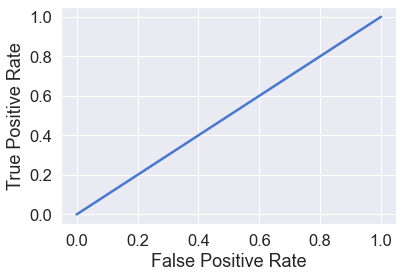

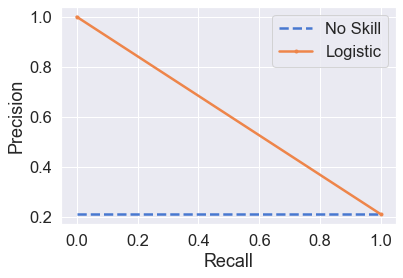


Finding Classification Report


Saving model SVM_AnomalyDetection 


t-SNE



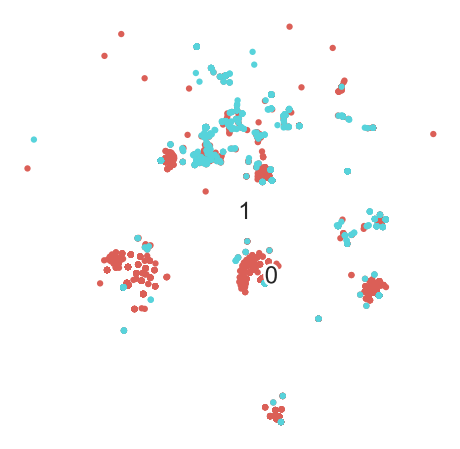


Loading File RFE10.xlsx

Performing 70.0/30.0 Train-Test Split

Shape of data: X_train: (3596, 10), y_train: (3596,), X_test: (1542, 10), y_test: (1542,)

Distribution of class labels:
Train:
0    2806
1     790
Name: ActivationLevel, dtype: int64

Test:
0    1220
1     322
Name: ActivationLevel, dtype: int64


Performing Logistic Regression



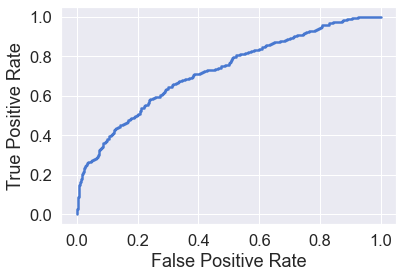

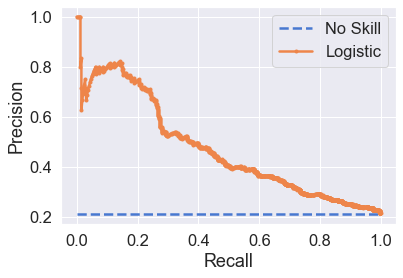

         Current function value: 0.455637
         Iterations: 35

Summary for Logit Model:

                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.128      
Dependent Variable: ActivationLevel  AIC:              4702.1307  
Date:               2023-03-06 17:24 BIC:              4767.5749  
No. Observations:   5138             Log-Likelihood:   -2341.1    
Df Model:           9                LL-Null:          -2683.8    
Df Residuals:       5128             LLR p-value:      8.9796e-142
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
STAB              -1.4740   0.1832  -8.0445 0.0000 -1.8331 -1.1149
CPR               -1.4694   0.1241 -11.8417 0.0000 -1.7126 -1

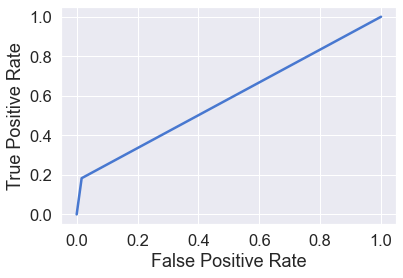

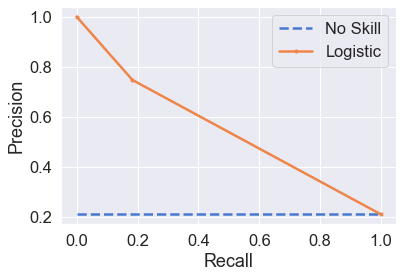


Finding Classification Report


Saving model SVM 


Performing KNN Regression

{'n_neighbors': 49, 'weights': 'distance'}


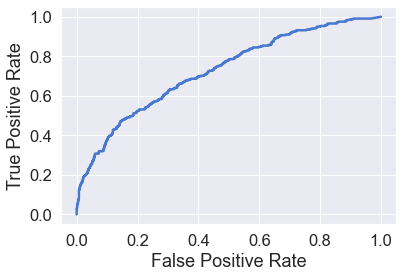

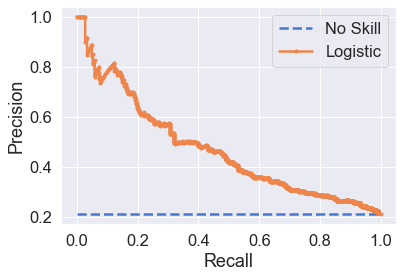


Finding Classification Report


Saving model KNNRegressor 


Performing KNN Classification

10 Features used during classification: ['STAB' 'CPR' 'ChestTube' 'ICP' 'Craniotomy' 'WorstPHSBP' 'WorstPHGCS'
 'BestPHPulse' 'WorstPHSBPNorm' 'Age']
{'n_neighbors': 33, 'weights': 'distance'}


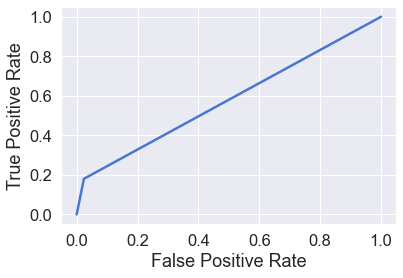

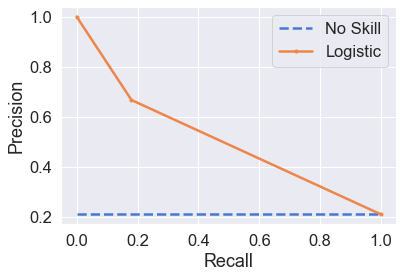


Finding Classification Report


Saving model KNNClassifier 


Performing Random Forest Regression



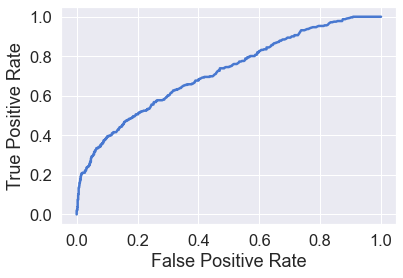

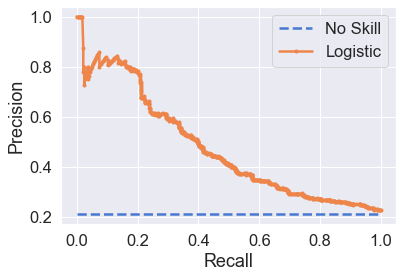

Variable: Age                  Importance: 0.31
Variable: BestPHPulse          Importance: 0.23
Variable: WorstPHSBP           Importance: 0.13
Variable: WorstPHSBPNorm       Importance: 0.13
Variable: WorstPHGCS           Importance: 0.12
Variable: ChestTube            Importance: 0.05
Variable: STAB                 Importance: 0.01
Variable: ICP                  Importance: 0.01
Variable: Craniotomy           Importance: 0.01
Variable: CPR                  Importance: 0.0

Finding Classification Report


Saving model RandomForestRegressor 


Performing Random Forest Classification


>0.1
Accuracy: 0.808 (0.012)

>0.2
Accuracy: 0.809 (0.012)

>0.3
Accuracy: 0.809 (0.011)

>0.4
Accuracy: 0.810 (0.011)

>0.5
Accuracy: 0.807 (0.012)

>0.6
Accuracy: 0.805 (0.012)

>0.7
Accuracy: 0.803 (0.010)

>0.8
Accuracy: 0.803 (0.010)

>0.9
Accuracy: 0.802 (0.012)

>1.0
Accuracy: 0.800 (0.012)

Performing Gaussian Naive Bayes


Finding Classification Report


Saving model GaussianNaiveBayes 


Perform

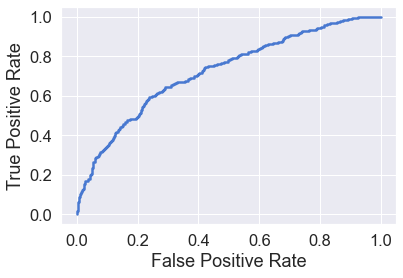

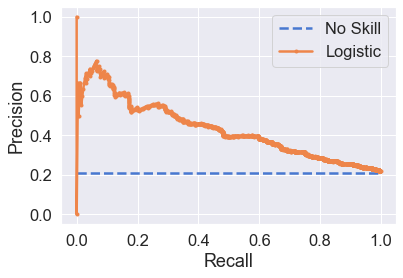

         Current function value: 0.455637
         Iterations: 35

Summary for Logit Model:

                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.128      
Dependent Variable: ActivationLevel  AIC:              4702.1307  
Date:               2023-03-06 17:26 BIC:              4767.5749  
No. Observations:   5138             Log-Likelihood:   -2341.1    
Df Model:           9                LL-Null:          -2683.8    
Df Residuals:       5128             LLR p-value:      8.9796e-142
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
STAB              -1.4740   0.1832  -8.0445 0.0000 -1.8331 -1.1149
CPR               -1.4694   0.1241 -11.8417 0.0000 -1.7126 -1

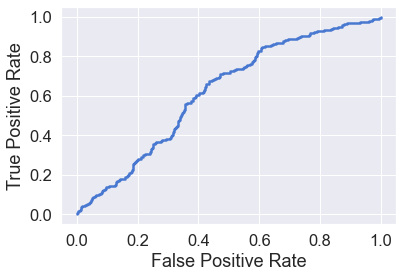

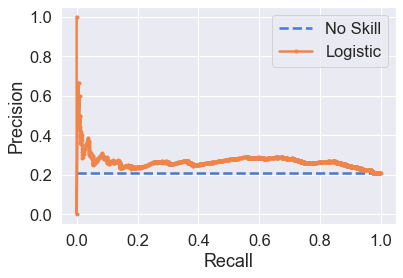


Finding Classification Report


Saving model KNNRegressor_AnomalyDetection 


Performing KNN Classification

10 Features used during classification: ['STAB' 'CPR' 'ChestTube' 'ICP' 'Craniotomy' 'WorstPHSBP' 'WorstPHGCS'
 'BestPHPulse' 'WorstPHSBPNorm' 'Age']
{'n_neighbors': 28, 'weights': 'distance'}


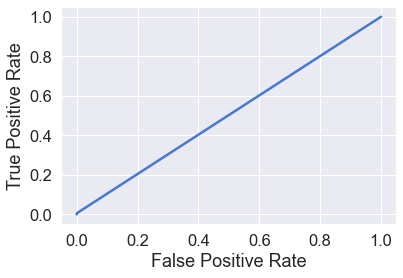

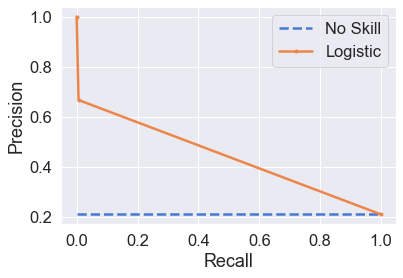


Finding Classification Report


Saving model KNNClassifier_AnomalyDetection 


Performing One Class SVM Anomaly Detection

(1332, 10) (1332,)

Performing SVM Classification

{'C': 1, 'degree': 2, 'kernel': 'linear'}

w =  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  7.18376813e-05 -1.65740140e-04  1.37216605e-04
   7.18341799e-05  5.49806671e-05]]

b =  [-0.999971]

Indices of support vectors =  [   6   11   17   28   46   49   53   61   65   69   78   83   87   91
   99  102  111  117  119  120  121  122  124  140  146  150  155  166
  167  176  180  182  184  185  201  220  238  240  261  282  288  299
  308  313  338  343  357  360  371  376  390  408  411  441  448  459
  463  468  477  488  497  501  505  512  514  518  521  542  548  554
  559  570  576  590  602  606  617  624  626  627  633  646  650  657
  661  664  665  670  672  677  689  692  697  701  707  710  720  726
  729  730  751  756  759  776  792  799  802  803  804  806  8

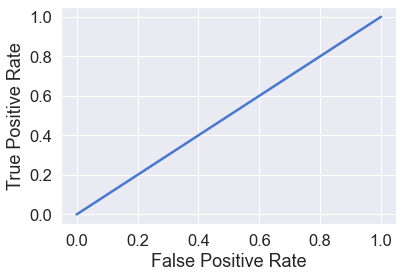

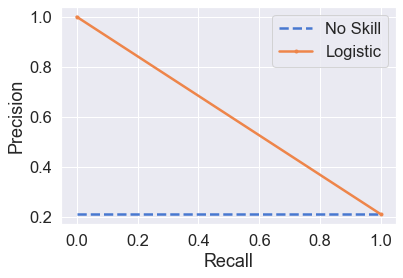


Finding Classification Report


Saving model SVM_AnomalyDetection 


t-SNE



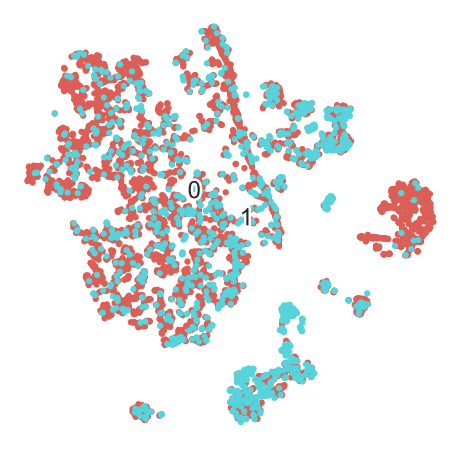


Loading File chi10.xlsx

Performing 70.0/30.0 Train-Test Split

Shape of data: X_train: (3596, 10), y_train: (3596,), X_test: (1542, 10), y_test: (1542,)

Distribution of class labels:
Train:
0    2806
1     790
Name: ActivationLevel, dtype: int64

Test:
0    1220
1     322
Name: ActivationLevel, dtype: int64


Performing Logistic Regression



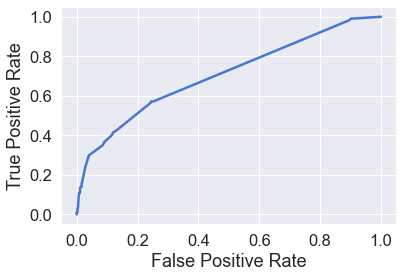

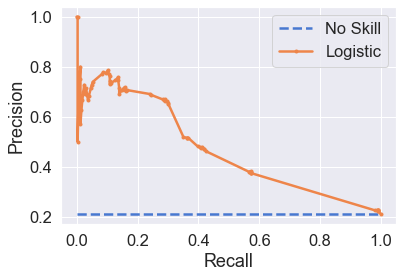

Optimization terminated successfully.
         Current function value: 0.636941
         Iterations 7

Summary for Logit Model:

                           Results: Logit
Model:               Logit             Pseudo R-squared:  -0.219   
Dependent Variable:  ActivationLevel   AIC:               6565.2032
Date:                2023-03-06 17:27  BIC:               6630.6474
No. Observations:    5138              Log-Likelihood:    -3272.6  
Df Model:            9                 LL-Null:           -2683.8  
Df Residuals:        5128              LLR p-value:       1.0000   
Converged:           1.0000            Scale:             1.0000   
No. Iterations:      7.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
STAB               -2.6611   0.1812 -14.6832 0.0000 -3.0164 -2.3059
O2           

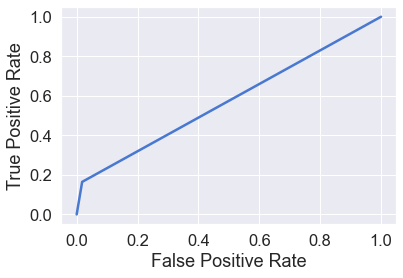

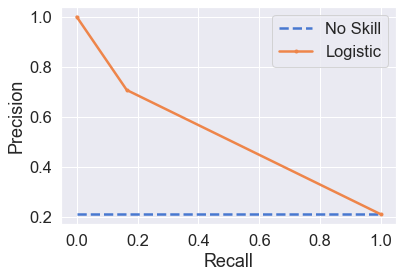


Finding Classification Report


Saving model SVM 


Performing KNN Regression

{'n_neighbors': 40, 'weights': 'uniform'}


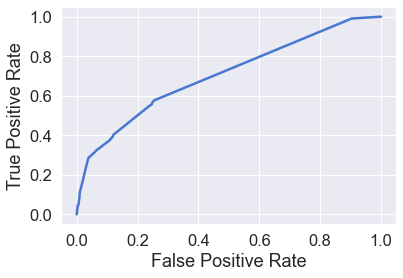

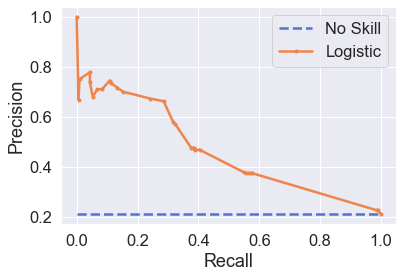


Finding Classification Report


Saving model KNNRegressor 


Performing KNN Classification

10 Features used during classification: ['STAB' 'O2' 'BVM' 'ETT' 'SUCK' 'NEEDLE' 'ChestTube' 'EmergentIntubation'
 'ICP' 'Craniotomy']
{'n_neighbors': 8, 'weights': 'uniform'}


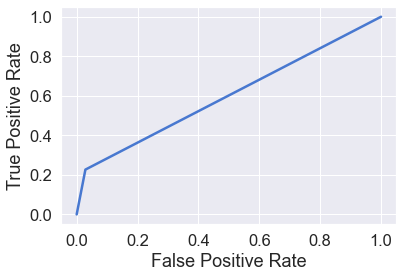

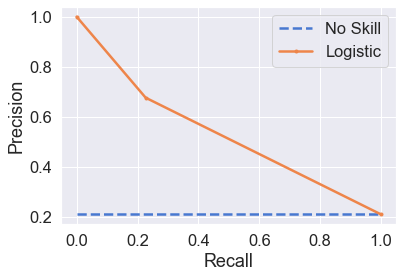


Finding Classification Report


Saving model KNNClassifier 


Performing Random Forest Regression



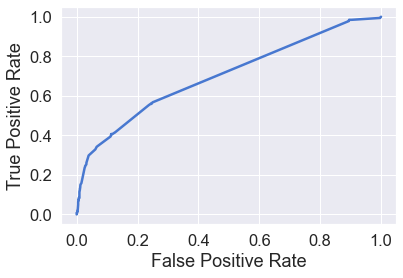

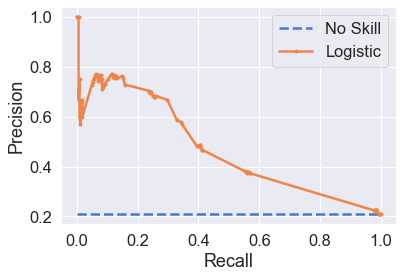

Variable: ChestTube            Importance: 0.29
Variable: EmergentIntubation   Importance: 0.18
Variable: O2                   Importance: 0.11
Variable: STAB                 Importance: 0.09
Variable: BVM                  Importance: 0.07
Variable: SUCK                 Importance: 0.07
Variable: ETT                  Importance: 0.06
Variable: ICP                  Importance: 0.05
Variable: Craniotomy           Importance: 0.05
Variable: NEEDLE               Importance: 0.04

Finding Classification Report


Saving model RandomForestRegressor 


Performing Random Forest Classification


>0.1
Accuracy: 0.804 (0.015)

>0.2
Accuracy: 0.805 (0.014)

>0.3
Accuracy: 0.803 (0.016)

>0.4
Accuracy: 0.803 (0.014)

>0.5
Accuracy: 0.803 (0.015)

>0.6
Accuracy: 0.803 (0.015)

>0.7
Accuracy: 0.803 (0.014)

>0.8
Accuracy: 0.802 (0.015)

>0.9
Accuracy: 0.803 (0.015)

>1.0
Accuracy: 0.803 (0.014)

Performing Gaussian Naive Bayes


Finding Classification Report


Saving model GaussianNaiveBayes 


Perfor

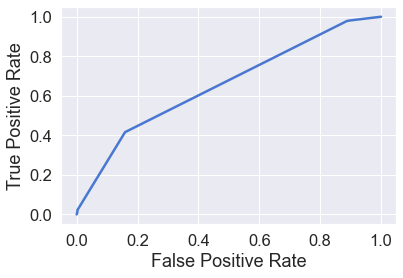

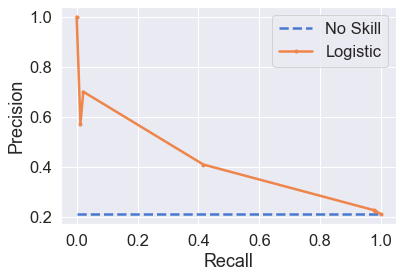

Optimization terminated successfully.
         Current function value: 0.636941
         Iterations 7

Summary for Logit Model:

                           Results: Logit
Model:               Logit             Pseudo R-squared:  -0.219   
Dependent Variable:  ActivationLevel   AIC:               6565.2032
Date:                2023-03-06 17:28  BIC:               6630.6474
No. Observations:    5138              Log-Likelihood:    -3272.6  
Df Model:            9                 LL-Null:           -2683.8  
Df Residuals:        5128              LLR p-value:       1.0000   
Converged:           1.0000            Scale:             1.0000   
No. Iterations:      7.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
STAB               -2.6611   0.1812 -14.6832 0.0000 -3.0164 -2.3059
O2           

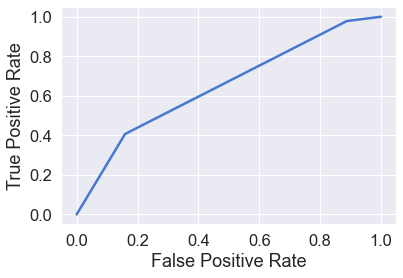

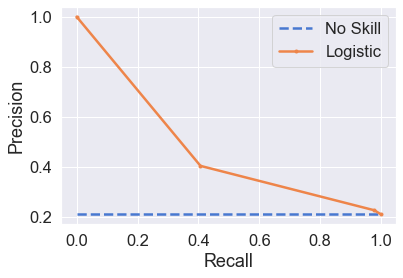


Finding Classification Report


Saving model KNNRegressor_AnomalyDetection 


Performing KNN Classification

10 Features used during classification: ['STAB' 'O2' 'BVM' 'ETT' 'SUCK' 'NEEDLE' 'ChestTube' 'EmergentIntubation'
 'ICP' 'Craniotomy']
{'n_neighbors': 1, 'weights': 'uniform'}


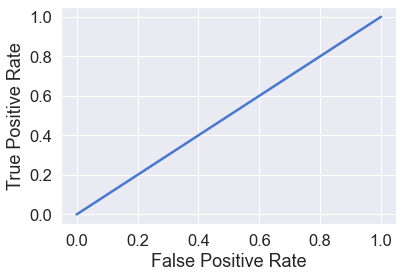

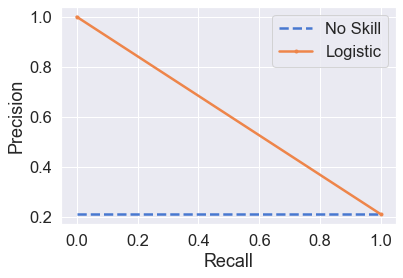


Finding Classification Report


Saving model KNNClassifier_AnomalyDetection 


Performing One Class SVM Anomaly Detection

(254, 10) (254,)

Performing SVM Classification

{'C': 1, 'degree': 2, 'kernel': 'linear'}

w =  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

b =  [-1.]

Indices of support vectors =  [249 250 251 252 253  21  56  67 165 190]

Support vectors =  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Number of support vectors for each class =  [5 5]

Coefficients of the support vector in the decision function =  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


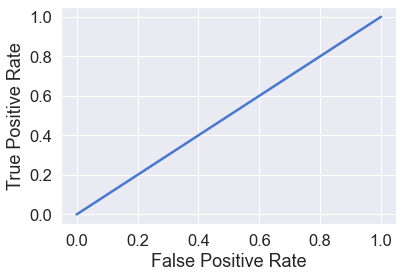

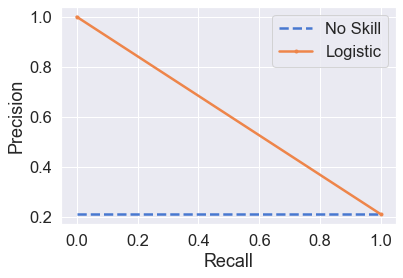


Finding Classification Report


Saving model SVM_AnomalyDetection 


t-SNE



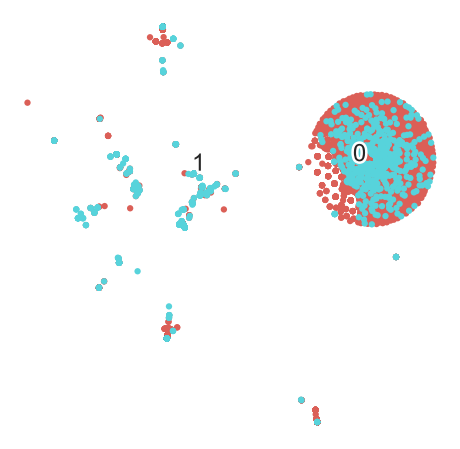

In [32]:
files = glob.glob("{}/{}/*.xlsx".format(data_folder_loc, folder_to_read_for_input_files))

for file_path in files:
    
    try:
        
        # Load Dataset
        file_name = file_path.split("/")[-1]
        data = load_dataset(file_path)
        data_features, data_labels = data.drop(target_level_column, axis=1), data.ActivationLevel
        X_train, X_test, y_train, y_test = perform_train_test_split(data_features, data_labels)
        print("\nShape of data: X_train: {}, y_train: {}, X_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
        print("\nDistribution of class labels:\nTrain:\n{}\n\nTest:\n{}\n".format(y_train.value_counts(), y_test.value_counts()))
        
        # Perform Classification Models
        reporting_df = perform_logistic_regression(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_svm(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_knn_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_knn_classifier(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        reporting_df = perform_random_forest_regressor(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        perform_random_forest_classifier(data_features, data_labels)
        reporting_df = perform_gaussian_naive_bayes(X_train, y_train, X_test, y_test, file_name, reporting_df)
        
        # Perform Anomaly Detection
        reporting_df = perform_anomaly_detection(X_train, y_train, X_test, y_test, file_name, reporting_df, data_folder_loc, folder_to_save_model)
        
        # Show t-SNE cluster image
        create_tsne(data, target_level_column, data_folder_loc, folder_to_save_model, file_name)
    
    except Exception as e:
        print("\nException Occured: {}\n".format(e))
            
reporting_df
reporting_df.to_excel("{}/{}/{}".format(data_folder_loc, folder_to_save_model, 'ModelOutput.xlsx'), index=False)